#**Modelado de la serie de tiempo usando métodos de Aprendizaje Automático**

### **Preparar el notebook**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

### **Cargar los datos preparados**

In [5]:
dfsuro = pd.read_csv('/content/drive/MyDrive/ProyectoIntegrador2/datos_suroeste.csv')

In [6]:
print(dfsuro.shape)
dfsuro.head()

(4117, 16)


,Unnamed: 0,ID,ELEMENTO,NODO,FECHA,COORD_LONG,COORD_LAT,REGION,SUBREGION,GRUPO_RESPONSABLE,CRITICIDAD_NUM,MUNICIPIO,CIRCUITO,PENDIENTE,ESTADO,tipo
0,3,14962964.0,FR46394,NaN,2023-02-10 20:34:35,-76.031442,6.135418,SUROESTE,AMAGA,DE25,64.0,5847.0,507-12,TRABAJOS DE PODA,CERRADA,OT
1,10,4946322.0,F54128,NaN,2021-02-27 16:17:36,-75.949641,6.176642,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT
2,11,11918713.0,FR5175,NaN,2022-08-05 07:22:47,-75.945599,6.222647,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT
3,153,13222653.0,FR5144,553018.0,2022-10-14 16:36:05,-75.990291,6.171016,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT
4,156,4916076.0,F54165,NaN,2021-02-20 14:04:59,-75.918451,5.997762,SUROESTE,AMAGA,DE25,64.0,5209.0,518-13,TRABAJOS DE PODA,CANCELADA,OT


In [7]:
dfsuro.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [8]:
# Dar formato al campo FECHA
dfsuro['FECHA'] = pd.to_datetime(dfsuro['FECHA'], format='%Y-%m-%d %H:%M:%S.%f')
# Dar formato al campo ID
dfsuro['ID'] = dfsuro['ID'].astype(int)

In [9]:
dfsuro.dtypes

ID                            int64
ELEMENTO                     object
NODO                        float64
FECHA                datetime64[ns]
COORD_LONG                  float64
COORD_LAT                   float64
REGION                       object
SUBREGION                    object
GRUPO_RESPONSABLE            object
CRITICIDAD_NUM              float64
MUNICIPIO                   float64
CIRCUITO                     object
PENDIENTE                    object
ESTADO                       object
tipo                         object
dtype: object

### **Análisis de la serie de tiempo con frecuencia semanal**

In [10]:
dfsuro['fecha_semana'] = pd.to_datetime(dfsuro['FECHA']).dt.to_period('W')

In [11]:
dfsuro.head()

,ID,ELEMENTO,NODO,FECHA,COORD_LONG,COORD_LAT,REGION,SUBREGION,GRUPO_RESPONSABLE,CRITICIDAD_NUM,MUNICIPIO,CIRCUITO,PENDIENTE,ESTADO,tipo,fecha_semana
0,14962964,FR46394,NaN,2023-02-10 20:34:35,-76.031442,6.135418,SUROESTE,AMAGA,DE25,64.0,5847.0,507-12,TRABAJOS DE PODA,CERRADA,OT,2023-02-06/2023-02-12
1,4946322,F54128,NaN,2021-02-27 16:17:36,-75.949641,6.176642,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT,2021-02-22/2021-02-28
2,11918713,FR5175,NaN,2022-08-05 07:22:47,-75.945599,6.222647,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT,2022-08-01/2022-08-07
3,13222653,FR5144,553018.0,2022-10-14 16:36:05,-75.990291,6.171016,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT,2022-10-10/2022-10-16
4,4916076,F54165,NaN,2021-02-20 14:04:59,-75.918451,5.997762,SUROESTE,AMAGA,DE25,64.0,5209.0,518-13,TRABAJOS DE PODA,CANCELADA,OT,2021-02-15/2021-02-21


Se extrae la serie semanal, haciendo el conteo de eventos de Trabajos de Poda generados por semana

In [12]:
serie_suro = pd.DataFrame(dfsuro.groupby(['fecha_semana'])['ID'].count())

Se obtiene una serie con 182 observaciones

In [13]:
print(serie_suro.shape)

(182, 1)


Se renombra la columna para mayor claridad

In [14]:
serie_suro.rename(columns={'ID':'CANT_EVENTOS'},inplace=True)

In [15]:
serie_suro.head()

,CANT_EVENTOS
fecha_semana,
2019-10-28/2019-11-03,1
2019-11-04/2019-11-10,4
2019-11-11/2019-11-17,6
2019-11-18/2019-11-24,12
2019-11-25/2019-12-01,9


In [16]:
serie_suro.dtypes

CANT_EVENTOS    int64
dtype: object

<Axes: xlabel='fecha_semana'>

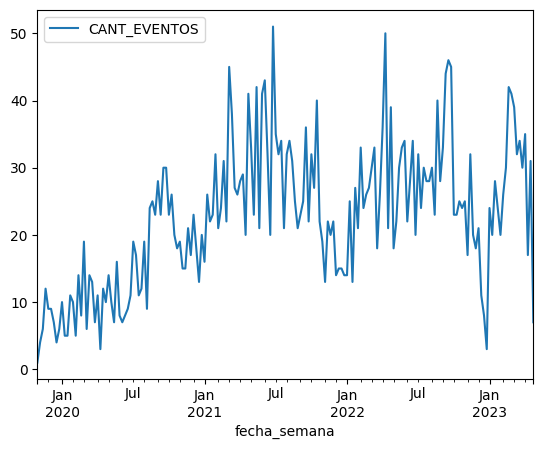

In [17]:
serie_suro.plot()

Se observa en la gráfica una tendencia creciente en la cantidad de eventos registrados. Esto se debe a un subregistro de los eventos en la etapa inicial de estabilización del sistema donde se almacenan los datos. Con el fin de evitar sesgos en las estimaciones se eliminarán los registros correspondientes a este periodo de estabilización

In [18]:
#Seleccionamos los datos de la serie que se usarán.
serie_suro=serie_suro.iloc[44:-1]
serie_suro

,CANT_EVENTOS
fecha_semana,
2020-08-31/2020-09-06,28
2020-09-07/2020-09-13,23
2020-09-14/2020-09-20,30
2020-09-21/2020-09-27,30
2020-09-28/2020-10-04,23
...,...
2023-03-13/2023-03-19,34
2023-03-20/2023-03-26,30
2023-03-27/2023-04-02,35


<Axes: xlabel='fecha_semana'>

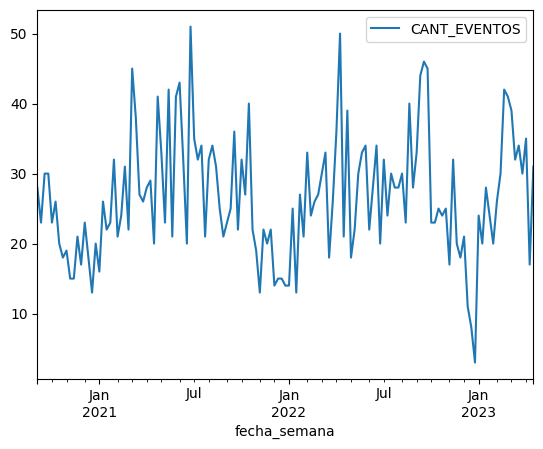

In [19]:
serie_suro.plot()

####**Transformación del conjunto de datos e incorporación de otras variables**


Se realiza una transformación de los datos para convertirlos a una estructura que facilite la aplicació de los modelos de aprendizaje automático

En primer lugar se modifica el índice de la serie de tiempo, correspondiente a un rango semanal, conservando únicamente la fecha inicial.

In [20]:
serie_suro.index = serie_suro.index.to_timestamp()

#####**Crear un data set supervisado**

Se reorganizarán los datos de la serie de tiempo, de manera que se obtenga un "*dataset* supervisado", con un número de rezagos de la serie como variables predictores $(x_1, x_2, ..., x_n)$  del valor actual de la serie $y$.

In [21]:
#obtener la serie de datos 
#eliminar los valores nulos
series = serie_suro.CANT_EVENTOS.dropna().to_numpy()

In [22]:
series

array([28, 23, 30, 30, 23, 26, 20, 18, 19, 15, 15, 21, 17, 23, 18, 13, 20,
       16, 26, 22, 23, 32, 21, 24, 31, 22, 45, 38, 27, 26, 28, 29, 20, 41,
       33, 23, 42, 21, 41, 43, 32, 20, 51, 35, 32, 34, 21, 32, 34, 31, 25,
       21, 23, 25, 36, 22, 32, 27, 40, 22, 19, 13, 22, 20, 22, 14, 15, 15,
       14, 14, 25, 13, 27, 21, 33, 24, 26, 27, 30, 33, 18, 26, 36, 50, 21,
       39, 18, 22, 30, 33, 34, 22, 28, 34, 20, 32, 24, 30, 28, 28, 30, 23,
       40, 28, 33, 44, 46, 45, 23, 23, 25, 24, 25, 17, 32, 20, 18, 21, 11,
        8,  3, 24, 20, 28, 24, 20, 26, 30, 42, 41, 39, 32, 34, 30, 35, 17,
       31])

Tomando como referencia los resultados de las funciones de autocorrelación y autocorrelación parcial, se usarán tres rezagos de la serie como variables predictoras del valor actual. 

In [23]:
T = 3
X = []
Y = []

for t in range(len(serie_suro.CANT_EVENTOS) -T):
  x = series[t: t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)
  
X = np.array(X).reshape(-1,T)
Y = np.array(Y)
N = len(X)
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape (134, 3) Y.shape (134,)


In [24]:
#Se crea un dataframe con los datos reorganizados
datos = pd.DataFrame(X, columns= ['x1', 'x2', 'x3'])
datos['y'] = Y

Se crea una variable *dummy* que refleje la condición de indisponibilidad del sistema de información donde se crean los eventos y se almacenan los datos (fechas donde han ocurrido este tipo de situaciones).

In [25]:
#Se crea sobre el dataframe una variable dummy con valor 1 
#para las fechas donde se tiene conocimiento de situaciones de indisponibilidad del sistema de información
dummy = np.where(serie_suro.index.isin(['2022-12-19 00:00:00', '2022-12-12 00:00:00', '2022-12-05 00:00:00']), 1, 0)
datos['dummy'] = dummy[3:]

**Datos de precipitaciones**

Como parte del entendimiento del negocio, se ha identificado una posible relación entre la cantidad de precipitaciones en la zona geográfica de estudio y la generación de eventos de poda en las redes de distribución.

Considerando lo anterior, se ha determinado incluir en el modelado los datos de precipitaciones capturados por cuatro estaciones de monitoreo ubicadas en la región en interés.

In [26]:
#Carga de los datos
df = pd.read_csv('/content/drive/MyDrive/ProyectoIntegrador2/Precipitaciones/precipitacion_suroeste.csv', encoding='latin-1')

In [27]:
precipitacion=df[['NombreEstacion','Fecha','Valor']]
precipitacion['Fecha'] = pd.to_datetime(precipitacion['Fecha'])
precipitacion

<ipython-input-27-f854ac561c41>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precipitacion['Fecha'] = pd.to_datetime(precipitacion['Fecha'])


,NombreEstacion,Fecha,Valor
0,BOLOMBOLO [26200130],2020-08-24,24.7
1,BOLOMBOLO [26200130],2020-08-25,0.0
2,BOLOMBOLO [26200130],2020-08-26,2.7
3,BOLOMBOLO [26200130],2020-08-27,0.0
4,BOLOMBOLO [26200130],2020-08-28,2.4
...,...,...,...
3849,URRAO [11075020],2023-04-12,4.5
3850,URRAO [11075020],2023-04-13,12.5
3851,URRAO [11075020],2023-04-14,0.0
3852,URRAO [11075020],2023-04-15,1.2


In [28]:
#Obtener la serie de datos para cada una de las estaciones de monitoreo
bolombolo=precipitacion[precipitacion['NombreEstacion']=='BOLOMBOLO [26200130]']
santabarbara=precipitacion[precipitacion['NombreEstacion']=='SANTA BARBARA [26190100]']
fredonia=precipitacion[precipitacion['NombreEstacion']=='FREDONIA [26200150]']
urrao=precipitacion[precipitacion['NombreEstacion']=='URRAO [11075020]']

In [29]:
#Agrupar los datos de precipitaciones en forma semanal 
#con el fin de darles la misma periodicidad de muestreo de la serie de datos de eventos
bolombolo_semanal = bolombolo.groupby([pd.Grouper(key='Fecha', freq='W')])['Valor'].sum()
santabarbara_semanal = santabarbara.groupby([pd.Grouper(key='Fecha', freq='W')])['Valor'].sum()
fredonia_semanal = fredonia.groupby([pd.Grouper(key='Fecha', freq='W')])['Valor'].sum()
urrao_semanal = urrao.groupby([pd.Grouper(key='Fecha', freq='W')])['Valor'].sum()

In [30]:
#Se adicionan los datos de precipitaciones al dataframe
datos['bolombolo'] = bolombolo_semanal[4:].values
datos['santabarbara'] = santabarbara_semanal[4:].values
datos['fredonia'] = fredonia_semanal[4:].values
datos['urrao'] = urrao_semanal[4:].values

In [31]:
datos

,x1,x2,x3,y,dummy,bolombolo,santabarbara,fredonia,urrao
0,28,23,30,30,0,71.7,39.9,67.0,12.7
1,23,30,30,23,0,78.3,47.0,130.0,64.1
2,30,30,23,26,0,68.2,25.6,23.0,46.6
3,30,23,26,20,0,32.9,33.8,49.0,32.0
4,23,26,20,18,0,22.0,18.3,60.0,56.1
...,...,...,...,...,...,...,...,...,...
129,41,39,32,34,0,68.0,63.0,112.0,24.7
130,39,32,34,30,0,0.0,19.8,13.0,3.1
131,32,34,30,35,0,2.4,49.2,45.0,14.4
132,34,30,35,17,0,5.4,76.5,26.0,1.0


**Adicionar el trimestre como variable predictora para modelar la estacionalidad de los datos**

In [32]:
trimestre = serie_suro.index.quarter

In [33]:
df_one_hot = pd.get_dummies(trimestre, prefix='trimestre')

In [34]:
df_one_hot = df_one_hot.iloc[3:].reset_index(drop = True)

In [35]:
df_one_hot

,trimestre_1,trimestre_2,trimestre_3,trimestre_4
0,0,0,1,0
1,0,0,1,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
129,1,0,0,0
130,1,0,0,0
131,1,0,0,0
132,0,1,0,0


In [36]:
datos = pd.concat([datos, df_one_hot], axis=1)

Ahora el conjunto de datos se compone de:
* el valor actual de los eventos ocurridos
* los valores de tres rezagos (eventos ocurridos en las tres semanas anteriores) 
* las precipitaciones registradas por las estaciones de monitoreo en la zona de interés
* la condición de indisponibilidad del sistema de información donde se registran los eventos
* el trimestre del año correspondiente a cada registro

In [37]:
datos.tail()

,x1,x2,x3,y,dummy,bolombolo,santabarbara,fredonia,urrao,trimestre_1,trimestre_2,trimestre_3,trimestre_4
129,41,39,32,34,0,68.0,63.0,112.0,24.7,1,0,0,0
130,39,32,34,30,0,0.0,19.8,13.0,3.1,1,0,0,0
131,32,34,30,35,0,2.4,49.2,45.0,14.4,1,0,0,0
132,34,30,35,17,0,5.4,76.5,26.0,1.0,0,1,0,0
133,30,35,17,31,0,20.8,59.9,27.0,30.2,0,1,0,0


**Escalar los datos numéricos**


In [38]:
datos.columns

Index(['x1', 'x2', 'x3', 'y', 'dummy', 'bolombolo', 'santabarbara', 'fredonia',
       'urrao', 'trimestre_1', 'trimestre_2', 'trimestre_3', 'trimestre_4'],
      dtype='object')

In [39]:
scaler = MinMaxScaler()
scaler.fit(datos[['x1', 'x2', 'x3', 'bolombolo', 'santabarbara', 'fredonia', 'urrao']])

MinMaxScaler()

In [40]:
datos[['x1', 'x2', 'x3', 'bolombolo', 'santabarbara', 'fredonia', 'urrao']]= scaler.transform(datos[['x1', 'x2', 'x3', 'bolombolo', 'santabarbara', 'fredonia', 'urrao']])

In [41]:
datos.head()

,x1,x2,x3,y,dummy,bolombolo,santabarbara,fredonia,urrao,trimestre_1,trimestre_2,trimestre_3,trimestre_4
0,0.520833,0.416667,0.562500,30,0,0.561912,0.258085,0.304545,0.082682,0,0,1,0
1,0.416667,0.562500,0.562500,23,0,0.613636,0.304010,0.590909,0.417318,0,0,1,0
2,0.562500,0.562500,0.416667,26,0,0.534483,0.165589,0.104545,0.303385,0,0,0,1
3,0.562500,0.416667,0.479167,20,0,0.257837,0.218629,0.222727,0.208333,0,0,0,1
4,0.416667,0.479167,0.354167,18,0,0.172414,0.118370,0.272727,0.365234,0,0,0,1


**Dividir el conjunto de datos en set de entrenamiento y set de prueba**

In [42]:
#se define el número de periodos que serán usados como conjunto de datos de entrenamiento

Ntest = 12
train = datos.iloc[:-Ntest]
test = datos.iloc[-Ntest:]

In [43]:
X_train = train[['x1', 'x2', 'x3', 'dummy', 'bolombolo','santabarbara', 'fredonia', 'urrao', 'trimestre_1', 'trimestre_2', 'trimestre_3', 'trimestre_4']]
X_test = test[['x1', 'x2', 'x3','dummy','bolombolo', 'santabarbara', 'fredonia', 'urrao', 'trimestre_1', 'trimestre_2', 'trimestre_3', 'trimestre_4']]

In [44]:
Y_train = train.y
Y_test = test.y

In [45]:
train_idx = datos.index <= train.index[-1]
test_idx = datos.index > train.index[-1]

### **Modelos de aprendizaje automático**

####**Regresión Lineal**

In [46]:
X_labels = ['x1', 'x2', 'x3', 'bolombolo', 'santabarbara', 'fredonia', 'urrao', 'trimestre_1', 'trimestre_2', 'trimestre_3', 'trimestre_4']

In [47]:
X_smf = ' + '.join(X_labels)
f = 'y ~ {}'.format(X_smf)

In [48]:
#Se define el modelo y se ajusta sobre los datos de prueba
model_lr = smf.ols(formula=f, data=pd.concat([X_train, Y_train], axis=1)).fit()

In [49]:
print(model_lr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     6.698
Date:                Tue, 06 Jun 2023   Prob (F-statistic):           4.45e-08
Time:                        18:54:28   Log-Likelihood:                -409.61
No. Observations:                 122   AIC:                             841.2
Df Residuals:                     111   BIC:                             872.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       14.5771      2.598      5.611   

**Calcular el error del modelo en el conjunto de entrenamiento**

In [50]:
#Se hace la predicción de los valores para el conjunto de datos de entrenamiento
Y_train_pred = model_lr.predict(X_train)

In [51]:
mse_train = mean_squared_error(Y_train, Y_train_pred)
print("Linear Model RMSE - Train Set: ", np.sqrt(mse_train))

Linear Model RMSE - Train Set:  6.948722031631884


**Calcular el error del modelo en el conjunto de prueba**

In [52]:
#Se hace la predicción de los valores para el conjunto de datos de entrenamiento
Y_test_pred = model_lr.predict(X_test)

In [80]:
mse_test = mean_squared_error(Y_test, Y_test_pred)
print("Error de la predicción")
print("Linear Model RMSE - Test Set: ", np.sqrt(mse_test))
print("Linear Model MAE - Test Set: ", mean_absolute_error(Y_test, Y_test_pred))

Error de la predicción
Linear Model RMSE - Test Set:  8.175075666422122
Linear Model MAE - Test Set:  6.452344873174685


**Almacenar los resultados de la predicción**

In [55]:
#crear un dataframe para almacenar los resultados de la predicción 
forecast = datos[['y']]

In [56]:
#obtener la serie de datos con el valor de la predicción  
Y_test_pred = pd.Series(Y_test_pred, name='test_pred_RL')
Y_train_pred = pd.Series(Y_train_pred, name='train_pred_RL')

In [57]:
forecast = forecast.merge(Y_test_pred, how = 'left', left_index = True, right_index = True)
forecast = forecast.merge(Y_train_pred, how = 'left', left_index = True, right_index = True)

####**Red Neuronal**

In [58]:
datos

,x1,x2,x3,y,dummy,bolombolo,santabarbara,fredonia,urrao,trimestre_1,trimestre_2,trimestre_3,trimestre_4
0,0.520833,0.416667,0.562500,30,0,0.561912,0.258085,0.304545,0.082682,0,0,1,0
1,0.416667,0.562500,0.562500,23,0,0.613636,0.304010,0.590909,0.417318,0,0,1,0
2,0.562500,0.562500,0.416667,26,0,0.534483,0.165589,0.104545,0.303385,0,0,0,1
3,0.562500,0.416667,0.479167,20,0,0.257837,0.218629,0.222727,0.208333,0,0,0,1
4,0.416667,0.479167,0.354167,18,0,0.172414,0.118370,0.272727,0.365234,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,0.791667,0.750000,0.604167,34,0,0.532915,0.407503,0.509091,0.160807,1,0,0,0
130,0.750000,0.604167,0.645833,30,0,0.000000,0.128072,0.059091,0.020182,1,0,0,0
131,0.604167,0.645833,0.562500,35,0,0.018809,0.318241,0.204545,0.093750,1,0,0,0
132,0.645833,0.562500,0.666667,17,0,0.042320,0.494825,0.118182,0.006510,0,1,0,0


**Definir la arquitectura y entrenar la red neuronal**

In [59]:
#Definir la red neuronal
i = Input(shape = (12,))
x = Dense(32, activation = 'relu')(i)
x = Dense(1)(x)
model = Model(i,x)
model.compile(loss= "mse", optimizer = 'adam', metrics= 'mae')

In [60]:
#Entrenar la red neuronal
r = model.fit(
    X_train,
    Y_train,
    epochs = 200,
    validation_data = (X_test, Y_test)
    )

Epoch 1/200
4/4 [==============================] - 1s 74ms/step - loss: 711.4980 - mae: 25.2379 - val_loss: 995.4624 - val_mae: 30.6648
Epoch 2/200
4/4 [==============================] - 0s 18ms/step - loss: 705.9161 - mae: 25.1287 - val_loss: 987.9854 - val_mae: 30.5456
Epoch 3/200
4/4 [==============================] - 0s 12ms/step - loss: 700.1643 - mae: 25.0159 - val_loss: 980.4608 - val_mae: 30.4252
Epoch 4/200
4/4 [==============================] - 0s 13ms/step - loss: 694.3936 - mae: 24.9042 - val_loss: 972.8406 - val_mae: 30.3028
Epoch 5/200
4/4 [==============================] - 0s 22ms/step - loss: 688.5331 - mae: 24.7891 - val_loss: 965.1663 - val_mae: 30.1787
Epoch 6/200
4/4 [==============================] - 0s 20ms/step - loss: 682.6058 - mae: 24.6706 - val_loss: 957.3987 - val_mae: 30.0521
Epoch 7/200
4/4 [==============================] - 0s 13ms/step - loss: 676.5381 - mae: 24.5488 - val_loss: 949.5231 - val_mae: 29.9230
Epoch 8/200
4/4 [==============================]

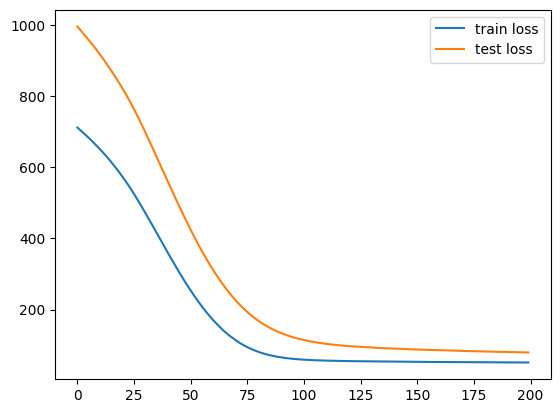

In [61]:
plt.plot( r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend();

**Realizar la predicción sobre los conjuntos de entrenamiento y de prueba**

In [62]:
Ptrain = model.predict(X_train)
Ptest = model.predict(X_test)

1/1 [==============================] - 0s 26ms/step


In [63]:
# Guardar los datos de las predicciones
datos.loc[train_idx, 'y_train_pred'] = Ptrain
datos.loc[test_idx, 'y_test_pred'] = Ptest

In [64]:
cols = ['y', 'y_train_pred', 'y_test_pred']

**Graficar los resultados de la predicción**

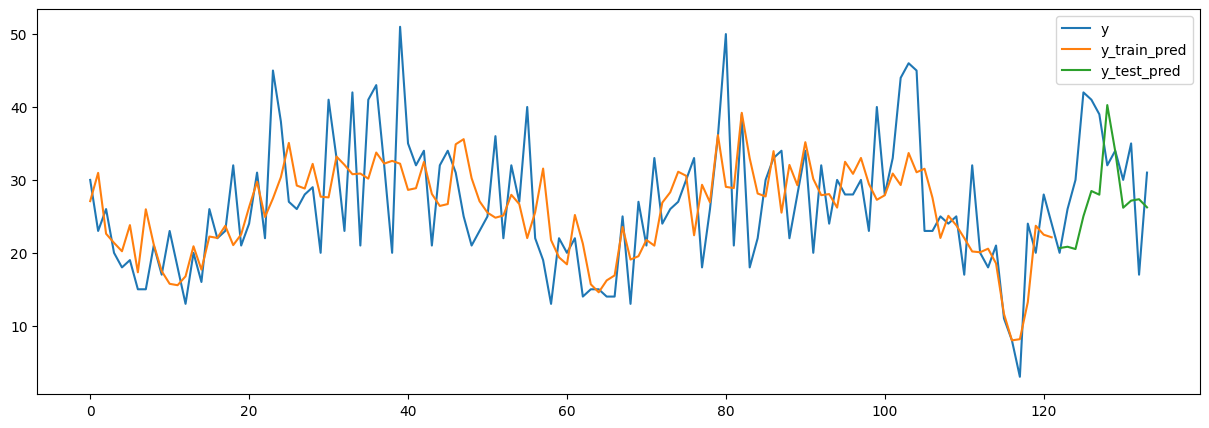

In [65]:
datos[cols].plot(figsize = (15,5));

**Hiperametrización del modelo**

In [66]:
#Se define una función para la creación del modelo

input_dim = len(X_train.columns)

def create_model(hidden_units_l1=16, hidden_units_l2 = 64, activation='relu', optimizer = 'adam'):
    model = Sequential()
    model.add(Dense(hidden_units_l1, activation=activation, input_shape=(input_dim,)))
    model.add(Dense(hidden_units_l2, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss="mse", metrics=['mae'])
    print(hidden_units_l1, hidden_units_l2, optimizer)
    return model

In [67]:
#Se definen el conjunto de valores a probar
param_grid = {
    'hidden_units_l1': [32, 64],
    'hidden_units_l2': [128, 256],
    'optimizer': ['adam', 'RMSprop'],
    ##'activation': ['relu']
}

In [68]:
#ejecución del gridsearch
model = KerasRegressor(build_fn=create_model, epochs=100)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, Y_train)

32 128 adam
Epoch 1/100


<ipython-input-68-d2b7a0159224>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, epochs=100)


3/3 [==============================] - 1s 5ms/step - loss: 740.8417 - mae: 25.8257
Epoch 2/100
3/3 [==============================] - 0s 6ms/step - loss: 733.2074 - mae: 25.6796
Epoch 3/100
3/3 [==============================] - 0s 8ms/step - loss: 725.7196 - mae: 25.5343
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 717.9067 - mae: 25.3839
Epoch 5/100
3/3 [==============================] - 0s 5ms/step - loss: 709.9631 - mae: 25.2276
Epoch 6/100
3/3 [==============================] - 0s 5ms/step - loss: 701.5106 - mae: 25.0614
Epoch 7/100
3/3 [==============================] - 0s 6ms/step - loss: 692.1049 - mae: 24.8782
Epoch 8/100
3/3 [==============================] - 0s 5ms/step - loss: 682.0974 - mae: 24.6751
Epoch 9/100
3/3 [==============================] - 0s 5ms/step - loss: 670.5975 - mae: 24.4463
Epoch 10/100
3/3 [==============================] - 0s 5ms/step - loss: 657.9990 - mae: 24.1896
Epoch 11/100
3/3 [==============================] - 0s 6ms/st

2/2 [==============================] - 0s 13ms/step - loss: 58.6399 - mae: 5.7974
32 128 RMSprop
Epoch 1/100
3/3 [==============================] - 1s 11ms/step - loss: 776.3500 - mae: 26.3565
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: 756.2733 - mae: 25.9781
Epoch 3/100
3/3 [==============================] - 0s 9ms/step - loss: 738.6339 - mae: 25.6457
Epoch 4/100
3/3 [==============================] - 0s 10ms/step - loss: 720.2057 - mae: 25.2990
Epoch 5/100
3/3 [==============================] - 0s 10ms/step - loss: 700.4092 - mae: 24.9103
Epoch 6/100
3/3 [==============================] - 0s 15ms/step - loss: 679.3389 - mae: 24.4959
Epoch 7/100
3/3 [==============================] - 0s 11ms/step - loss: 656.3847 - mae: 24.0402
Epoch 8/100
3/3 [==============================] - 0s 9ms/step - loss: 631.8089 - mae: 23.5383
Epoch 9/100
3/3 [==============================] - 0s 12ms/step - loss: 605.8692 - mae: 22.9958
Epoch 10/100
3/3 [=======================

2/2 [==============================] - 0s 6ms/step - loss: 51.6566 - mae: 5.3787
32 128 RMSprop
Epoch 1/100
3/3 [==============================] - 2s 5ms/step - loss: 742.1965 - mae: 25.8132
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 721.9284 - mae: 25.4359
Epoch 3/100
3/3 [==============================] - 0s 5ms/step - loss: 704.9309 - mae: 25.1079
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 688.4632 - mae: 24.7759
Epoch 5/100
3/3 [==============================] - 0s 7ms/step - loss: 671.7931 - mae: 24.4475
Epoch 6/100
3/3 [==============================] - 0s 5ms/step - loss: 653.6683 - mae: 24.0711
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 634.3938 - mae: 23.6744
Epoch 8/100
3/3 [==============================] - 0s 6ms/step - loss: 613.9620 - mae: 23.2415
Epoch 9/100
3/3 [==============================] - 0s 5ms/step - loss: 592.2709 - mae: 22.7843
Epoch 10/100
3/3 [==============================]

Mejores parámetros para obtener el mejor valor de la métrica

In [69]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -54.157820 using {'hidden_units_l1': 32, 'hidden_units_l2': 256, 'optimizer': 'adam'}


Resumen del resultado del gridsearch

In [70]:
print("Grid Search Results Summary:")
print("----------------------------")
results = grid_result.cv_results_
for mean_score, params in zip(results["mean_test_score"], results["params"]):
    print("Mean Score:", mean_score)
    print("Parameters:", params)
    print("-----------------------------------")

Grid Search Results Summary:
----------------------------
Mean Score: -57.25326029459635
Parameters: {'hidden_units_l1': 32, 'hidden_units_l2': 128, 'optimizer': 'adam'}
-----------------------------------
Mean Score: -54.98285802205404
Parameters: {'hidden_units_l1': 32, 'hidden_units_l2': 128, 'optimizer': 'RMSprop'}
-----------------------------------
Mean Score: -54.15782038370768
Parameters: {'hidden_units_l1': 32, 'hidden_units_l2': 256, 'optimizer': 'adam'}
-----------------------------------
Mean Score: -56.52704874674479
Parameters: {'hidden_units_l1': 32, 'hidden_units_l2': 256, 'optimizer': 'RMSprop'}
-----------------------------------
Mean Score: -55.45481618245443
Parameters: {'hidden_units_l1': 64, 'hidden_units_l2': 128, 'optimizer': 'adam'}
-----------------------------------
Mean Score: -55.10119756062826
Parameters: {'hidden_units_l1': 64, 'hidden_units_l2': 128, 'optimizer': 'RMSprop'}
-----------------------------------
Mean Score: -56.64532216389974
Parameters: {'

**Hacer la predicción sobre los conjuntos de entrenamiento y pruebas**

In [71]:
#Asignar el mejor modelo a una variable
model_def = grid_result.best_estimator_

In [72]:
#Hacer la predicción
Ptrain = model_def.predict(X_train)
Ptest = model_def.predict(X_test)

1/1 [==============================] - 0s 37ms/step


**Almacenar los resultados de la predicción**

In [73]:
datos.loc[train_idx, 'y_train_pred'] = Ptrain
datos.loc[test_idx, 'y_test_pred'] = Ptest

In [74]:
datos

,x1,x2,x3,y,dummy,bolombolo,santabarbara,fredonia,urrao,trimestre_1,trimestre_2,trimestre_3,trimestre_4,y_train_pred,y_test_pred
0,0.520833,0.416667,0.562500,30,0,0.561912,0.258085,0.304545,0.082682,0,0,1,0,28.856258,NaN
1,0.416667,0.562500,0.562500,23,0,0.613636,0.304010,0.590909,0.417318,0,0,1,0,30.195585,NaN
2,0.562500,0.562500,0.416667,26,0,0.534483,0.165589,0.104545,0.303385,0,0,0,1,22.194639,NaN
3,0.562500,0.416667,0.479167,20,0,0.257837,0.218629,0.222727,0.208333,0,0,0,1,21.148233,NaN
4,0.416667,0.479167,0.354167,18,0,0.172414,0.118370,0.272727,0.365234,0,0,0,1,19.878342,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,0.791667,0.750000,0.604167,34,0,0.532915,0.407503,0.509091,0.160807,1,0,0,0,NaN,33.935677
130,0.750000,0.604167,0.645833,30,0,0.000000,0.128072,0.059091,0.020182,1,0,0,0,NaN,28.493774
131,0.604167,0.645833,0.562500,35,0,0.018809,0.318241,0.204545,0.093750,1,0,0,0,NaN,28.840405
132,0.645833,0.562500,0.666667,17,0,0.042320,0.494825,0.118182,0.006510,0,1,0,0,NaN,29.878883


**Calcular el error de la predicción sobre el conjunto de prueba**

In [83]:
print("Error de la predicción")
mse_NN_test = mean_squared_error(Y_test, Ptest)
print("NN model RMSE - Test Set: ", np.sqrt(mse_NN_test))
mae_NN_test = mean_absolute_error(Y_test, Ptest)
print("NN model MAE - Test Set: ", mae_NN_test)

Error de la predicción
NN model RMSE - Test Set:  8.008045025267881
NN model MAE - Test Set:  6.485680262247722


**Graficar los resultados de la predicción**

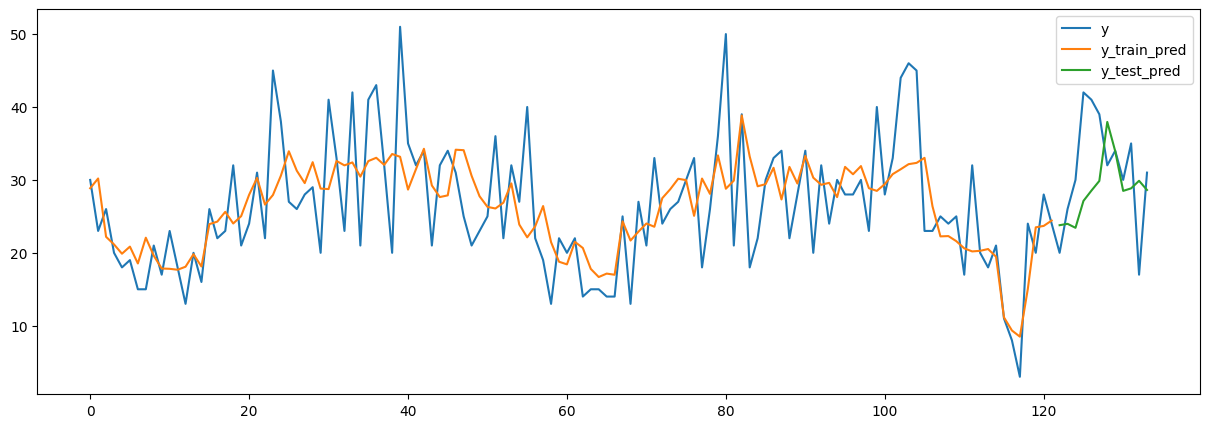

In [77]:
datos[cols].plot(figsize = (15,5));

**Exportar los datos y resultados obtenidos**

In [78]:
forecast[['test_pred_NN']]= datos[['y_test_pred']]
forecast[['train_pred_NN']]= datos[['y_train_pred']]

In [79]:
forecast.to_csv('/content/drive/MyDrive/ProyectoIntegrador2/datos_export/forecast_ML_NN.csv')